# How to build a reliable, curated, and accurate RAG system using Cleanlab and Pinecone

Retrieval-Augmented Generation (RAG) is a powerful technique in natural language processing that combines the strengths of large language models with external knowledge retrieval. RAG systems enhance the capabilities of AI models by allowing them to access and utilize relevant information from a curated knowledge base, leading to more accurate, up-to-date, and context-aware responses. Building a reliable, curated, and accurate RAG system is crucial for several reasons:

- **Improved Accuracy:** By retrieving relevant information, RAG systems can provide more precise and factual responses.
- **Reduced Hallucinations:** Access to external knowledge helps minimize the risk of AI models generating false or inconsistent information.
- **Adaptability:** RAG systems can be easily updated with new information without retraining the entire model.
- **Trustworthiness:** The ability to trace responses back to source documents enhances explainability and trust in AI-generated content.

In this notebook, we'll explore how to build such a system using [Cleanlab](https://cleanlab.ai/) and Pinecone.
Cleanlab is a company that specializes in data-centric AI, focusing on improving the quality and reliability of AI/ML systems. Cleanlab's Trustworthy Language Model (TLM) is designed to add trust and reliability to AI model outputs and indicate when it's unsure of an answer, making it ideal for applications where unchecked hallucinations could be problematic. This is especially the case for anyone trying to build generative AI applications in production. 

Pinecone, as a vector database solution, excels in storing and retrieving high-dimensional vectors, making it perfect for managing and querying large-scale document embeddings.

By combining Cleanlab's TLM with Pinecone's vector database capabilities, we can create a RAG system that not only retrieves relevant information efficiently but also ensures the quality and reliability of the data being used. This notebook will guide you through the process of:

1. Using Cleanlab's TLM to tag and clean document data, removing low-quality chunks and personally identifiable information (PII).
2. Leveraging Pinecone to create and manage a vector database for storing and retrieving document embeddings.
3. Implementing a RAG pipeline that uses both tools to provide accurate and trustworthy responses.
4. Utilizing Cleanlab's TLM to classify metadata, enhance retrieval, and evaluate the trustworthiness of RAG outputs.

By the end of this notebook, you'll have a robust understanding of how to build a RAG system that prioritizes reliability, curation, and accuracy, setting a strong foundation for developing trustworthy AI applications.


![Reliable RAG with Pinecone and Cleanlab](cleanlab_pinecone_RAG.png)

Let's install dependencies to run the notebook and then import our libraries:

In [ ]:
%pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import os
import pinecone
import uuid
from pinecone import ServerlessSpec
from sentence_transformers import SentenceTransformer
from typing import List, Tuple, Dict, Optional
from IPython import display
from tqdm import tqdm
from difflib import SequenceMatcher
import re

warnings.simplefilter(action="ignore", category=FutureWarning)
display.clear_output()

In [2]:
if "PINECONE_API_KEY" not in os.environ:
    os.environ["PINECONE_API_KEY"] = input("Please enter your Pinecone API key: ")

Below is an example of how to set a Python index serverless specification, this allows us to define the cloud provider and region where we want to deploy our index. You can find a list of all [available providers and regions here](https://docs.pinecone.io/docs/projects).

In [3]:
cloud = os.environ.get("PINECONE_CLOUD") or "aws"
region = os.environ.get("PINECONE_REGION") or "us-east-1"

spec = ServerlessSpec(cloud=cloud, region=region)

## Load Documents Data

Let's read in our documents data that we will use in this workflow. The data columns include the `filename` of the document and the document `text`.

In [4]:
# Read in dataset
df = pd.read_csv("documents-RAG-demo.csv")
print(df.shape)

(103, 3)


In [5]:
df.head()

,index,filename,text
0,0,documents/Blackstone-Third-Quarter-2023-Invest...,Blackstone Third Quarter 2023 Investor Call Oc...
1,1,documents/8k-nike.pdf,SECURITIES AND EXCHANGE COMMISSIONFORM 8-K Cur...
2,2,documents/FY24-Q1-NIKE-Press-Release.pdf,NaN
3,3,documents/10-K 2022-Apple2.pdf,The future principal payments for the Company’...
4,4,documents/q3-fy22-earnings-presentation.pdf,Financial\tpresentation\tto\t accompany\tmanag...


## Use Cleanlab's TLM to tag your documents with a topic

For our RAG system, it would be ideal to tag each of our documents with a particular topic that is most relevant (based on the text content), which can be used as [metadata](https://docs.pinecone.io/guides/data/filter-with-metadata) we can filter with during retrieval in our RAG system. 

We can now use Cleanlab's [Trustworthy Language Model](https://cleanlab.ai/blog/trustworthy-language-model/) to tag our document chunks with the correct document topic that we can later use to enhance our retrieval process of fetching the correct context from our vector DB.

Cleanlab's Trustworthy Language Model (TLM) is a more reliable LLM that gives high-quality outputs and indicates when it is unsure of the answer to a question, making it suitable for applications where unchecked hallucinations are a show-stopper.

### Installing Cleanlab TLM

Using TLM requires a [Cleanlab](https://app.cleanlab.ai/) account. Sign up for one [here](https://cleanlab.ai/signup/) if you haven't yet. If you've already signed up, check your email for a personal login link.

Cleanlab's Python client can be installed using pip below (but the correct version used in this tutorial was installed in `requirements.txt` at the beginning of this notebook):

In [ ]:
%pip install -U cleanlab-studio

## Using the TLM

You can use the TLM pretty much like any other LLM API:

In [6]:
from cleanlab_studio import Studio

key = "Please enter your Cleanlab API key"

# Get API key from here: https://app.cleanlab.ai/account after creating an account.
studio = Studio(key)

# Use the most powerful OpenAI model with TLM
tlm = studio.TLM(quality_preset="high", options={"model": "gpt-4o"})

output = tlm.prompt("<your prompt>")

Let's now use Cleanlab's TLM to do classification and classify the text (tag) into different topics. We will make use of code from [Cleanlab's TLM Zero-Shot Classification Tutorial](https://help.cleanlab.ai/tutorials/zero_shot_classification/) to do this. This includes the two helper functions `parse_category()` and `classify()` that can be found below.

In [7]:
# Helper Functions

def parse_category(
    response: str,
    categories: List[str],
    disable_warnings: bool = False
) -> str:
    """
    Extracts one of the provided categories from the response using regex patterns.
    
    If no category out of the possible categories is directly mentioned in the response, 
    the category with greatest string similarity to the response is returned (along with a warning).
    
    Args:
        response (str): Response from the LLM
        categories (List[str]): List of expected categories
        disable_warnings (bool): If True, print warnings are disabled
    
    Returns:
        str: The extracted or best-matching category
    """
    response_str = str(response)
    escaped_categories = [re.escape(output) for output in categories]
    categories_pattern = "(" + "|".join(escaped_categories) + ")"

    exact_matches = re.findall(categories_pattern, response_str, re.IGNORECASE)
    if len(exact_matches) > 0:
        return str(exact_matches[-1])

    best_match = max(
        categories, key=lambda x: SequenceMatcher(None, response_str, x).ratio()
    )
    similarity_score = SequenceMatcher(None, response_str, best_match).ratio()

    if similarity_score < 0.5:
        warning_message = f"None of the categories remotely match raw LLM output: {response_str}.\nReturning the last entry in the constrain outputs list."
        best_match = categories[-1]
    else:
        warning_message = f"None of the categories match raw LLM output: {response_str}"

    if not disable_warnings:
        warnings.warn(warning_message)

    return best_match

def classify(texts: List[str], categories: List[str], prompt_template: str) -> Tuple[List[str], List[float]]:
    """
    Classifies a list of texts into predefined categories using a language model.
    
    Args:
        texts (List[str]): List of texts to classify
        categories (List[str]): List of possible categories
        prompt_template (str): Template string for formatting the prompt
    
    Returns:
        Tuple[List[str], List[float]]: A tuple containing two lists:
            - List of predicted categories for each text
            - List of trustworthiness scores for each prediction
    """
    prompts = [prompt_template.format(text=text) for text in texts]
    outputs = tlm.try_prompt(prompts)
    
    responses = [output['response'] for output in outputs]
    trustworthiness_scores = [output['trustworthiness_score'] for output in outputs]
    
    predictions = [parse_category(response, categories) for response in responses]
    
    return predictions, trustworthiness_scores


Now we can define the prompt and categories we will use to tag our documents with the correct topic.

In [8]:
# Use Cleanlab's TLM to tag your documents with a topic
tagging_prompt = """
You are an assistant for tagging text as one of several topics. The available topics are:

1. 'finance': Related to financial matters, budgeting, accounting, investments, lending, or monetary policies.
2. 'hr': Pertaining to Human Resources, including hiring, employee documents (such as a W4 form), employee management, benefits, or workplace policies.
3. 'it': Covering Information Technology topics such as software development, network infrastructure, cybersecurity, or tech support.
4. 'product': Dealing with a specific company product, product development, management, features, or lifecycle.
5. 'sales': Involving selling a product, customer acquisition, revenue generation, or sales performance.

If you are not sure which topic to tag the text with, then answer 'unknown'.

Task: Analyze the following text and determine the topic it belongs to. Return the topic as a string.

Now here is the Text to verify:

Text: {text}

Topic: 
"""

categories = ['finance', 'hr', 'it', 'product', 'sales', 'unknown']

Next we will use our helper functions to tag our documents with the correct topic.

In [9]:
predictions, trustworthiness_scores = classify(df["text"].tolist(), categories, tagging_prompt)

topics_df = df.copy()
topics_df['topic'] = predictions
topics_df['topic_trustworthiness'] = trustworthiness_scores

Querying TLM... 100%|██████████|


In [10]:
# Display results
topics_df.head()

,index,filename,text,topic,topic_trustworthiness
0,0,documents/Blackstone-Third-Quarter-2023-Invest...,Blackstone Third Quarter 2023 Investor Call Oc...,finance,0.964745
1,1,documents/8k-nike.pdf,SECURITIES AND EXCHANGE COMMISSIONFORM 8-K Cur...,finance,0.962081
2,2,documents/FY24-Q1-NIKE-Press-Release.pdf,NaN,unknown,0.967972
3,3,documents/10-K 2022-Apple2.pdf,The future principal payments for the Company’...,finance,0.966044
4,4,documents/q3-fy22-earnings-presentation.pdf,Financial\tpresentation\tto\t accompany\tmanag...,finance,0.957310


As seen above, after running `classify()`, you will notice two new columns in the dataset: 

- `topic`, a column with the response that we prompted for 
- `topic_trustworthiness`, a corresponding trustworthiness score, which quantifies how confident you can be that the response is correct

Now we can use the [Trustworthiness Score](https://help.cleanlab.ai/tutorials/tlm/#how-does-the-tlm-trustworthiness-score-work) obtained in our results (as `topic_trustworthiness`) to analyze which of our topic responses are the most trustworthy and least trustworthy.

For our use case, at a low enough threshold score for `topic_trustworthiness`, we can replace the `topic` value for those responses with `unknown` since we can't be sure to trust those responses.

This threshold can be determined by sorting the results by the trustworthiness score and then looking for a cutoff point in the results when topic values seem unstrustworthy.

In practice, generally speaking, if you have the time/resources, your team can manually review low-trustworthiness responses and provide a better human response instead. If not, you can determine a trustworthiness threshold below which responses seem untrustworthy, and automatically append a warning statement to any response whose trustworthiness falls below the threshold or flag those responses in the appropriate way for your use case.

The overall magnitude/range of the trustworthiness scores may differ between datasets, so we recommend selecting any thresholds to be application-specific. First consider the relative trustworthiness levels between different data points before considering the overall magnitude of these scores for individual data points.

In [11]:
sorted_topic_df = topics_df.sort_values(
    by="topic_trustworthiness", ascending=False
).copy()
sorted_topic_df.head(10)

,index,filename,text,topic,topic_trustworthiness
96,96,documents/selling-on-amazon-welcome.pdf,The beginner’s guide toSelling on AmazonWelcom...,sales,0.992463
76,76,documents/elk-lighting.pdf,ITEM DIMENSIONSWidth 9 inches Depth 10 inches ...,product,0.992439
83,83,documents/frigidaire-window-unit.pdf,"15,100 BTU Connected Window-Mounted Room Air C...",product,0.991497
68,68,documents/danby-10cuft-fridge.pdf,Danby 10.1 cu.ft Apartment Size Refrigerator D...,product,0.991480
77,77,documents/berenson_95721014.pdf,Product SpecificationsCollectionPURITANProduct...,product,0.990659
73,73,documents/moen-single-handle-faucent.pdf,SpecificationsDESCRIPTION Reflex™ pulldown sys...,product,0.990609
78,78,documents/allwood-spec-sheet.pdf,"At Allwood, we embrace the beauty and variatio...",product,0.990523
74,74,documents/furniture-specsheet.pdf,Tag:Product:Manufacturer:Manufacturer No.:Desc...,product,0.990290
31,31,documents/hiring-process-infographic.pdf,County of Santa ClaraHiring Options For Manage...,hr,0.990061
94,94,documents/how-to-sell-your-product.pdf,TipConcentrate on Building RelationshipsGettin...,sales,0.989818


In [12]:
sorted_topic_df.tail(10)

,index,filename,text,topic,topic_trustworthiness
57,57,documents/IT-policy.pdf,Internet and Technology Safety Policy Agreemen...,it,0.940355
24,24,documents/fw4.pdf,Form W-4 (2015)Purpose. Complete Form W-4 so t...,hr,0.932192
21,21,documents/the-behavioral-interview-presentatio...,THE BEHAVIORAL INTERVIEW TECHNIQUEPresented by...,hr,0.920229
54,54,documents/Computer-Equipment-Request.pdf,COMPUTER EQUIPMENT REQUEST FORM Please use thi...,it,0.914987
35,35,documents/Research-Assistant.pdf,Job Description and Responsibilities forResear...,hr,0.823999
17,17,documents/Investor-Transcript-Werner-Enterpris...,18PRESENTATIONOperatorGood afternoon and welco...,finance,0.803787
8,8,documents/LD_Trucost_Company_Presentation_0504...,Quantitative Environmental Performance Measure...,product,0.773626
20,20,documents/UnreleasedGames.doc,EVERY GAME THAT WAS NEVER RELEASED FOR THE SPE...,sales,0.607633
59,59,documents/internetsafety.ppt,Santa Rosa District SchoolsINTERNET SAFETYNove...,it,0.567766
58,58,documents/ElectricalRequestForm.pdf,Use this form to request parts and equipment f...,it,0.317711


After sorting the results in descending order by the `topic_trustworthiness` score, the results seem to be less trustworthy for scores less than 0.8.

Let's replace each of these less trustworthy`topic` responses with `unknown` now.

In [13]:
topics_df.loc[topics_df["topic_trustworthiness"] < 0.8, "topic"] = (
    "unknown"
)

To get a sense of the distribution of topics we've tagged in our documents data, let's plot the distribution now:


Topic Column Distribution:
topic
hr         29
product    19
finance    18
sales      16
unknown    12
it          9
Name: count, dtype: int64

Topic Percentage Distribution:
topic
hr         28.155340
product    18.446602
finance    17.475728
sales      15.533981
unknown    11.650485
it          8.737864
Name: proportion, dtype: float64


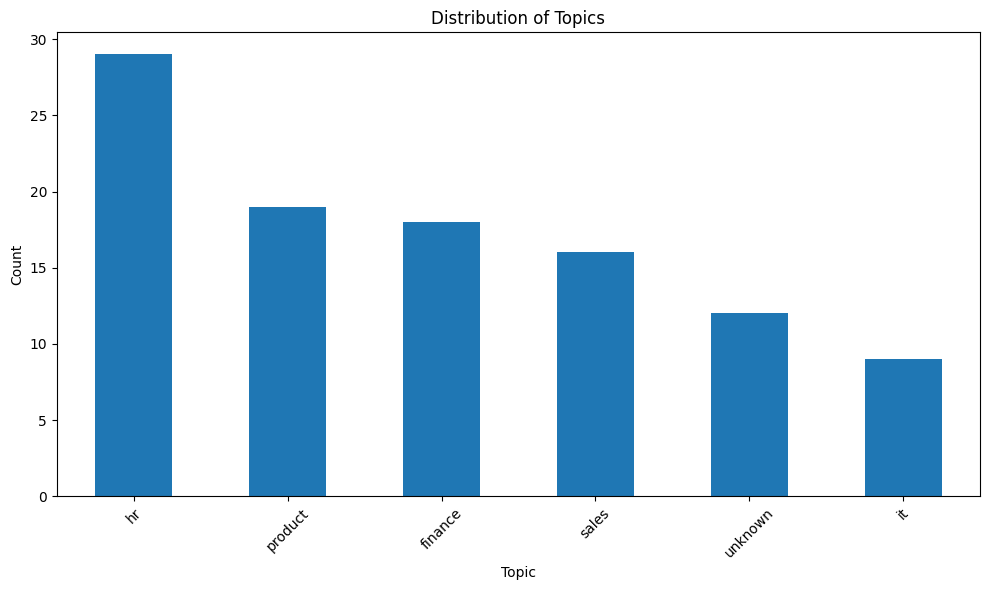

In [14]:
topic_counts = topics_df["topic"].value_counts(dropna=False)
print(f"\nTopic Column Distribution:\n{topic_counts}")

# Percentage distribution of topics
topic_percentages = topics_df["topic"].value_counts(normalize=True) * 100
print(f"\nTopic Percentage Distribution:\n{topic_percentages}")

# Visualize topic distribution
plt.figure(figsize=(10, 6))
topic_counts.plot(kind="bar")
plt.title("Distribution of Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Initialize RAG Pipeline using our documents data

In [15]:
import os
import uuid
from typing import List, Dict, Optional, Tuple

import pandas as pd
import pinecone
from sentence_transformers import SentenceTransformer

class PineconeRAGPipeline:
    def __init__(
        self,
        model_name: str = "paraphrase-MiniLM-L6-v2",
        index_name: str = "document-index",
        cloud: str = "aws",
        region: str = "us-east-1",
    ):
        """
        Initialize the PineconeRAGPipeline with a specified model and index name.

        Args:
            model_name (str): Name of the SentenceTransformer model to use.
            index_name (str): Name of the Pinecone index to create or connect to.
            cloud (str): Cloud provider for Pinecone.
            region (str): Region for the Pinecone service.
        """
        self.model = SentenceTransformer(model_name)
        if not os.environ.get("PINECONE_API_KEY"):
            os.environ["PINECONE_API_KEY"] = "YOUR PINECONE API KEY HERE"
        self.pc = pinecone.Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
        self.index_name = index_name

        existing_indexes = self.pc.list_indexes()

        if self.index_name not in existing_indexes:
            try:
                print(f"Creating new index: {self.index_name}")
                self.pc.create_index(
                    name=self.index_name,
                    dimension=self.model.get_sentence_embedding_dimension(),
                    metric="cosine",
                    spec=pinecone.ServerlessSpec(cloud=cloud, region=region),
                )
            except Exception as e:
                if "ALREADY_EXISTS" in str(e):
                    print(
                        f"Index {self.index_name} already exists. Connecting to existing index."
                    )
                else:
                    raise e
        else:
            print(
                f"Index {self.index_name} already exists. Connecting to existing index."
            )

        self.index = self.pc.Index(self.index_name)

    def chunk_text(self, text: str, max_tokens: int = 256) -> List[str]:
        """
        Split text into chunks based on a maximum token size.

        Args:
            text (str): The document text to be chunked.
            max_tokens (int): The maximum number of tokens per chunk.

        Returns:
            List[str]: List of text chunks.
        """
        words = text.split()
        chunks = []
        current_chunk = []
        current_chunk_tokens = 0

        for word in words:
            word_tokens = len(self.model.tokenize([word])["input_ids"][0])
            if current_chunk_tokens + word_tokens > max_tokens and current_chunk:
                chunks.append(" ".join(current_chunk))
                current_chunk = []
                current_chunk_tokens = 0

            current_chunk.append(word)
            current_chunk_tokens += word_tokens

        if current_chunk:
            chunks.append(" ".join(current_chunk))

        for i, chunk in enumerate(chunks):
            print(
                f"Chunk {i+1} length: {len(chunk)} characters, "
                f"{len(self.model.tokenize([chunk])['input_ids'][0])} tokens"
            )

        return chunks

    def index_documents(self, df: pd.DataFrame) -> int:
        """
        Index documents from a DataFrame with specific metadata structure.

        Args:
            df (pd.DataFrame): DataFrame containing document information and metadata.
                               Expected columns: 'text', 'filename', 'topic'

        Returns:
            int: The number of chunks successfully indexed.
        """
        valid_docs = []
        valid_metadata = []
        generated_ids = []

        print("Starting document processing...")

        for idx, row in df.iterrows():
            if pd.isna(row["text"]) or pd.isna(row["filename"]) or pd.isna(row["topic"]):
                print(f"Skipping invalid document at index {idx}: {row['filename']}")
                continue

            doc = str(row["text"])
            print(f"Processing document {row['filename']} at index {idx}...")

            chunks = self.chunk_text(doc)

            for i, chunk in enumerate(chunks):
                chunk_id = str(uuid.uuid4())
                chunk_metadata = {
                    "filename": row["filename"],
                    "topic": row["topic"],
                    "chunk_index": i,
                    "total_chunks": len(chunks),
                    "chunk_id": chunk_id,
                }
                valid_docs.append(chunk)
                valid_metadata.append(chunk_metadata)
                generated_ids.append(chunk_id)

        print(f"Total chunks to encode: {len(valid_docs)}")

        if not valid_docs:
            print("No valid documents to index.")
            return 0

        doc_embeddings = self.model.encode(valid_docs)

        batch_size = 100
        for i in range(0, len(valid_docs), batch_size):
            batch_docs = valid_docs[i : i + batch_size]
            batch_metadata = valid_metadata[i : i + batch_size]
            batch_embeddings = doc_embeddings[i : i + batch_size]

            vectors = [
                (
                    generated_ids[i + j],
                    embedding.tolist(),
                    {**metadata, "text": doc[:1000]},
                )
                for j, (doc, embedding, metadata) in enumerate(
                    zip(batch_docs, batch_embeddings, batch_metadata)
                )
            ]

            try:
                self.index.upsert(vectors=vectors)
                print(f"Successfully indexed batch of {len(vectors)} chunks.")
            except Exception as e:
                print(f"Error during upsert: {e}")

        print("Document indexing completed.")
        return len(valid_docs)

    def search(
        self, query: str, top_k: int = 5, filter_query: Optional[Dict] = None
    ) -> List[Tuple[str, Dict]]:
        """
        Search for the top_k most relevant documents based on the input query and optional filter.

        Args:
            query (str): The search query text.
            top_k (int): The number of top relevant documents to return.
            filter_query (Optional[Dict]): Optional filter query to apply during search.

        Returns:
            List[Tuple[str, Dict]]: List of top_k relevant document texts and their metadata.
                                    Each tuple contains (document_text, metadata_dict).
        """
        query_embedding = self.model.encode(query)

        try:
            results = self.index.query(
                vector=query_embedding.tolist(),
                top_k=top_k,
                filter=filter_query,
                include_metadata=True,
            )

            return [
                (
                    match.metadata["text"],
                    {k: v for k, v in match.metadata.items() if k != "text"},
                )
                for match in results.matches
            ]
        except Exception as e:
            print(f"Error during search: {e}")
            return []

    def delete_index(self) -> None:
        """
        Delete the Pinecone index.

        Raises:
            Exception: If there's an error during the deletion process.
        """
        try:
            self.pc.delete_index(self.index_name)
            print(f"Index '{self.index_name}' has been deleted.")
        except Exception as e:
            print(f"Error deleting index: {e}")

    def extract_all_chunks_from_index(self, max_chunks: int = 10000) -> pd.DataFrame:
        """
        Extract all document chunks and metadata from the Pinecone index into a DataFrame.

        Args:
            max_chunks (int): Maximum number of chunks to retrieve.

        Returns:
            pd.DataFrame: DataFrame containing chunk data and metadata.
                          Columns include all metadata fields stored in the index.

        Raises:
            Exception: If there's an error retrieving chunks from the index.
        """
        stats = self.index.describe_index_stats()
        total_vectors = stats.total_vector_count
        dimension = stats.dimension

        print(f"Index name: {self.index_name}")
        print(f"Total vectors according to stats: {total_vectors}")
        print(f"Vector dimension: {dimension}")

        try:
            results = self.index.query(
                vector=[0.0] * dimension,
                top_k=max_chunks,
                include_values=False,
                include_metadata=True,
            )

            chunk_data = [match.metadata for match in results.matches]
            chunk_df = pd.DataFrame(chunk_data)

            print(f"Total chunks retrieved: {len(chunk_df)}")
            return chunk_df

        except Exception as e:
            print(f"Error retrieving chunks from index: {e}")
            return pd.DataFrame()

    def delete_chunks(self, chunk_ids: List[str]) -> None:
        """
        Delete specific chunks from the Pinecone index.

        Args:
            chunk_ids (List[str]): List of chunk IDs to delete.

        Raises:
            Exception: If there's an error during the deletion process.
        """
        try:
            self.index.delete(ids=chunk_ids)
            print(f"Successfully deleted {len(chunk_ids)} chunks from the index.")
        except Exception as e:
            print(f"Error deleting chunks: {e}")
            print(f"Problematic chunk IDs: {chunk_ids}")

        print(f"Finished deletion process for {len(chunk_ids)} chunks.")

Let's use the RAG pipeline we have defined above to create a Pinecone index - then we upsert our document chunks into our vector DB in batches.

In [17]:
# Create RAG pipeline on unfiltered documents
rag_pipeline = PineconeRAGPipeline(index_name="cleanlab-pinecone-index")
rag_pipeline.index_documents(topics_df)

Creating new index: cleanlab-pinecone-index
Starting document processing...
Processing document documents/Blackstone-Third-Quarter-2023-Investor-Call.pdf at index 0...
Chunk 1 length: 465 characters, 106 tokens
Chunk 2 length: 492 characters, 102 tokens
Chunk 3 length: 462 characters, 98 tokens
Chunk 4 length: 464 characters, 108 tokens
Chunk 5 length: 428 characters, 106 tokens
Chunk 6 length: 465 characters, 94 tokens
Chunk 7 length: 551 characters, 110 tokens
Chunk 8 length: 509 characters, 100 tokens
Chunk 9 length: 449 characters, 99 tokens
Chunk 10 length: 499 characters, 98 tokens
Chunk 11 length: 515 characters, 96 tokens
Chunk 12 length: 531 characters, 106 tokens
Chunk 13 length: 520 characters, 104 tokens
Chunk 14 length: 570 characters, 102 tokens
Chunk 15 length: 498 characters, 100 tokens
Chunk 16 length: 483 characters, 100 tokens
Chunk 17 length: 485 characters, 104 tokens
Chunk 18 length: 532 characters, 97 tokens
Chunk 19 length: 541 characters, 99 tokens
Chunk 20 len

2432

After upserting our document chunks, let's now confirm that the upsertion worked properly (after waiting 30 seconds to give the vector DB time to update) by reading the document chunks into a new DataFrame `chunk_df`.

In [18]:
time.sleep(30)

# Extract chunks from the Pinecone index into a DataFrame
chunk_df = rag_pipeline.extract_all_chunks_from_index()

# Display the resulting DataFrame
chunk_df.head()

Index name: cleanlab-pinecone-index
Total vectors according to stats: 2432
Vector dimension: 384
Total chunks retrieved: 2432


,chunk_id,chunk_index,filename,text,topic,total_chunks
0,93b8208c-ed08-4dca-bc3a-f0a3a851e647,4.0,documents/Walmart_2022_Investor_Information.pdf,follows:2023HighLow1st Quarter(1)$146.94$132.0...,finance,9.0
1,c77a729a-2099-4563-b9f6-95bbe91b57a1,5.0,documents/2012_14.doc,Pay transactions on HUE01 using the following ...,hr,17.0
2,5509e93a-bfe6-4692-a793-b68999e62bd2,5.0,documents/internet_safety.pptx,"751-5980 (800) 487-1626 (8 a.m. to 5 p.m. CST,...",it,6.0
3,6352bd45-9d99-4f86-98e9-26edd34ce6ce,139.0,documents/Investor_Transcript_2023-10-26.pdf,"PROVIDE AN ACCURATE TRANSCRIPTION, THERE MAY B...",finance,141.0
4,a21c6510-2a56-4a1f-89ee-17da5d2f3994,12.0,documents/2012_14.doc,When entering deduction override amounts for a...,hr,17.0


In [22]:
chunk_df.shape

(2432, 6)

In [23]:
document_data_columns = list(chunk_df.columns)
print(f"The columns in our documents data are: {document_data_columns}")

The columns in our documents data are: ['chunk_id', 'chunk_index', 'filename', 'text', 'topic', 'total_chunks']


We can see below that the number of chunks per document varies:

In [24]:
chunks_per_doc = chunk_df.groupby("filename")["chunk_index"].max() + 1
print(chunks_per_doc)

filename
documents/10-K 2022-Apple.pdf                                               3.0
documents/10-K 2022-Apple2.pdf                                             16.0
documents/2012_14.doc                                                      17.0
documents/2020_-_I-9_Employment_Verification_Training_Presentation.ppt     17.0
documents/2023-CEASampleEmployeeHandbook.doc                              286.0
                                                                          ...  
documents/the-selling-process-1.pdf                                         7.0
documents/the-selling-process-2.pdf                                        10.0
documents/unit04.pdf                                                       22.0
documents/what-is-selling.pptx                                              7.0
documents/work-ez-specs.pdf                                                 2.0
Name: chunk_index, Length: 95, dtype: float64


## Use Cleanlab's TLM to detect and filter out bad document chunks

Now that we have extracted our document chunks from our Pinecone index, let's use Cleanlab's TLM (via the helper functions we defined earlier to tag documents) to detect low quality document chunks (i.e. HTML, not interpretable/cut off phrases, or non English text) and personally identifiable information (PII) to filter out these chunks from our vector DB.

Below we define the prompts we will use to find the document chunks that are badly chunked or contain PII and run our `classify()` helper function to obtain the response and trustworthiness scores from TLM.

In [25]:
# Bad chunks detection
bad_chunks_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 

Task: Analyze the following text and determine if it's badly chunked. A badly chunked text can contain HTML, have text or phrases that are hard to understand, or be non english text. 

Return 'bad_chunk' if it's badly chunked, and 'good_chunk' if it's not. Please be as accurate as possible, the world depends on it.

Text: {text}
"""

bad_chunk_categories = ["bad_chunk", "good_chunk"]


In [26]:
bad_chunk_predictions, bad_chunk_scores = classify(chunk_df["text"].tolist(), bad_chunk_categories, bad_chunks_prompt)

chunk_df['chunk_quality'] = bad_chunk_predictions
chunk_df['chunk_quality_trustworthiness'] = bad_chunk_scores

Querying TLM... 100%|██████████|


In [27]:
# PII detection
pii_prompt = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 

Task: Analyze the following text and determine if it has personally identifiable information (PII). PII is information that could be used to identify an individual or is otherwise sensitive. Names, addresses, phone numbers are examples of common PII.

Return 'is_PII' if the text contains PII and 'no_PII' if it does not. Please be as accurate as possible, the world depends on it.

Text: {text}
"""

pii_categories = ["is_PII", "no_PII"]

In [28]:
pii_predictions, pii_scores = classify(chunk_df["text"].tolist(), pii_categories, pii_prompt)

chunk_df['pii_check'] = pii_predictions
chunk_df['pii_check_trustworthiness'] = pii_scores

Querying TLM... 100%|██████████|


In [29]:
sorted_chunk_quality_df = chunk_df.sort_values(
    by="chunk_quality_trustworthiness", ascending=False
).copy()
sorted_is_pii_df = chunk_df.sort_values(
    by="pii_check_trustworthiness", ascending=False
).copy()

Now let's check how many document chunks are bad chunks or contain PII but also in which the response trustworthiness score is >= 0.95, which represent the most trustworthy responses using TLM. 

In [30]:
worst_chunks = sorted_chunk_quality_df.query(
    "chunk_quality == 'bad_chunk' and chunk_quality_trustworthiness >= 0.95"
)
worst_pii = sorted_is_pii_df.query(
    "pii_check == 'is_PII' and pii_check_trustworthiness >= 0.95"
)

print(
    f"Number of document chunks that have the worst chunk quality based on trustworthiness: {worst_chunks.shape[0]}"
)
print(
    f"Number of document chunks have the worst PII based on trustworthiness: {worst_pii.shape[0]}"
)

Number of document chunks that have the worst chunk quality based on trustworthiness: 577
Number of document chunks have the worst PII based on trustworthiness: 107


We have observed the capabilities that Cleanlab's TLM can provide in detecting these low quality document chunks, so let's now:

1. Update our Pinecone DB by removing the chunks with any of the issues detected by Cleanlab
2. Verify that the update to our Pinecone DB worked

Let's observe some of the worst chunks that we are going to delete:

In [31]:
print(worst_chunks["text"][1311])
print("\n")
print(worst_chunks["text"][2065])

%20 %12 %2 %5 %15 %—13 %Cover Page Cover PageSep. 29, 2022Cover [Abstract] Document Type Document Period End Date Entity Registrant Name Entity Incorporation, State or Country Code OR Entity File Number Entity Tax Identification Number Entity Address, Address Line One Entity Address, City or Town Entity Address, State or Province Entity Address, Postal Zip Code City Area Code Local Phone Number Written Communications Soliciting Material Pre-commencement Tender Offer Pre-commencement Issuer Tender Offer Title of


______________________________________ Student ID#: ___________School: _________________________________________________________ Grade: ________________Parent/Guardian Signature: _________________________________________ Date: _________________Please return to your child’s school ONLY if you do not want them


These chunks are clearly not easy to understand nor do they represent full English phrases.

Now let's observe some of the worst examples of PII that we are going to delete:

In [32]:
print(worst_pii["text"][531])
print("\n")
print(worst_pii["text"][1081])

and install will vary on a case-by-case basis. Forms submitted with incomplete information will delay the decision-making process. PLEASE NOTE: Any requests may be considered for approval as a Pilot prior to full implementation, as determined by the Director of Academic Services, the Director of Pupil Services and the Director of Technology.Sam Jones01/01/24sjones@gmail.com561-555-1254Tori Pines404 Spruce Avenue, Paradise, NV 89109555-123-8172555-123-8173toripines@westlake.edu


AmbraAmbra 120 DBL BasePage 1/2CollectionModel |Dimensions Metric1 inch = 2.54 cm 1 inch = 25.4 mm 1051 Lea Drive - Collegeville, PA 19426 Tel. 215 513 9400 - Fax 610 831 0215 www.wsbathcollections.com - info@wsbathcollectins.comProduct Specs SheetsPowered by TCPDF (www.tcpdf.org)Powered by TCPDF (www.tcpdf.org)


These examples contain sensitive information such as phone numbers, email addresses and personal names that are flagged by Cleanlab - so these definitely contain PII that can be removed!

We can now construct the list of chunks to delete based on the `chunk_id` we previously created for each chunk that we can tie to each chunk in our vector DB.

In [33]:
# Get the chunk IDs for the chunks that have issues to update our Pinecone index
worst_chunks_to_delete_ids = worst_chunks["chunk_id"].tolist()
worst_pii_to_delete_ids = worst_pii["chunk_id"].tolist()
chunks_to_delete_ids = list(set(worst_chunks_to_delete_ids + worst_pii_to_delete_ids))

In [34]:
len(chunks_to_delete_ids)

663

In [38]:
# Delete the identified chunks from the index
rag_pipeline.delete_chunks(chunks_to_delete_ids)

Successfully deleted 663 chunks from the index.
Finished deletion process for 663 chunks.


After deleting our document chunks, let's now confirm that the deletion worked properly (after waiting 30 seconds to give the vector DB time to update) by reading the document chunks into a new DataFrame `updated_chunk_df`.

We will also then confirm the number of chunks deleted is equal to the total number of original chunks minus the number of chunks after filtering out bad chunks.

In [39]:
# Sleep timer to allow the deletion process to complete
time.sleep(30)

# Verify the update went through and we have the correct number of chunks
updated_chunk_df = rag_pipeline.extract_all_chunks_from_index()
updated_chunk_df.head()

Index name: cleanlab-pinecone-index
Total vectors according to stats: 1769
Vector dimension: 384
Total chunks retrieved: 1769


,chunk_id,chunk_index,filename,text,topic,total_chunks
0,5d6cff8b-a53f-4f60-a2a6-60b46417560d,2.0,documents/Blackstone-Third-Quarter-2023-Invest...,"release and slide presentation, which are avai...",finance,127.0
1,c1143934-3f34-4099-b452-6cc1a8036c2c,3.0,documents/Blackstone-Third-Quarter-2023-Invest...,10-K We'll also refer to certain non-GAAP meas...,finance,127.0
2,afe8ca91-78cb-4851-8f92-b8e682dbb3da,4.0,documents/Blackstone-Third-Quarter-2023-Invest...,"$1.2 billion, or $0.94 per common share, and w...",finance,127.0
3,a6026edc-c32b-4ef2-baea-23bcdb0a2ba9,5.0,documents/Blackstone-Third-Quarter-2023-Invest...,"shared human values, and we are deeply saddene...",finance,127.0
4,df61e9a8-7518-44a7-98a6-57a912e1e418,6.0,documents/Blackstone-Third-Quarter-2023-Invest...,"year-to-year basis. Higher interest rates, alo...",finance,127.0


In [40]:
# Confirm the number of chunks deleted is equal to the total number of original chunks minus the number of chunks after filtering out bad chunks
assert len(chunk_df) - len(updated_chunk_df) == len(chunks_to_delete_ids)

**Note:** You can also run this data ingestion (tagging, chunking, and cleaning) into a Pinecone vector DB index in real-time as new documents are being ingested. 

### How to search for documents with metadata

Below is an example on how you can search for your curated documents based on a query of your choice and use metadata to help filter for the relevant information. 

In this case, we specify `topic = sales` to find the `top k` (where k is number of results to return and equal to 2 here) documents that best match the search query/metadata filters.

In [41]:
results = rag_pipeline.search(
    query="Tell me about sales",  # YOUR SEARCH QUERY HERE
    top_k=2,
    filter_query={"topic": {"$eq": "sales"}},
)

for doc_text, metadata in results:
    print(f"Document: {doc_text[:100]}...")
    print(f"Metadata: {metadata}")
    print("-" * 500)

Document: learn the person’s name, position, age, education, experience, hobbies, etc. Many times, just gettin...
Metadata: {'chunk_id': 'aeb314c7-9d16-4c2d-859b-85d4a0b098c5', 'chunk_index': 5.0, 'filename': 'documents/the-selling-process-2.pdf', 'topic': 'sales', 'total_chunks': 10.0}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Document: often used in a streamlined sales process.You have completed the topic for the sales process. Thank ...
Metadata: {'chunk_id': '0087d732-8978-422e-a730-889d58d51026', 'chunk_index': 14.0, 'filename': '

## Use Cleanlab's TLM for intent classification to classify metadata

Suppose our user is asked which topic their question is about from a pre-defined list. Alternatively, we could train a classifier to predict the topic from the question (automatically using Cleanlab's TLM). This way, the intent classification is done automatically (and reliably) to obtain our topic that pertains to a user question. This topic can then be used for metadata filtering when querying against our vector DB.

In [42]:
# Intent classification
intent_classification_prompt = """
You are an assistant for classifying a question as one of several topics. The available topics are:

1. 'finance': Related to financial matters, budgeting, accounting, investments, lending, or monetary policies.
2. 'hr': Pertaining to Human Resources, including hiring, employee documents (such as a W4 form), employee management, benefits, or workplace policies.
3. 'it': Covering Information Technology topics such as software development, network infrastructure, cybersecurity, or tech support.
4. 'product': Dealing with a specific company product, product development, management, features, or lifecycle.
5. 'sales': Involving selling a product, customer acquisition, revenue generation, or sales performance.

If you are not sure which topic to classify the question as, then answer 'unknown'.

Task: Analyze the following question and determine the topic it belongs to. Return the topic as a string.

Now here is the question to verify:

Text: {text}

Topic: 
"""

In [43]:
question = "What were Blackstone's fee-related earnings in the third quarter of 2023?"

Using the question and prompt defined above, let's now use TLM to classify the question into the correct topic (intent classification) that we will use as the metadata to filter our vector DB query with:

In [44]:
intent_predictions, intent_trustworthiness_scores = classify([question], categories, intent_classification_prompt)

metadata_topic_response = {
    "metadata_response": intent_predictions[0],
    "metadata_trustworthiness_score": intent_trustworthiness_scores[0]
}

print(metadata_topic_response)

# Extract the topic from the response
metadata_topic = metadata_topic_response["metadata_response"]

Querying TLM... 100%|██████████|

{'metadata_response': 'finance', 'metadata_trustworthiness_score': 0.9782569595638215}


Below, you can then specify the classified metadata topic (or other relevant metadata) when filtering to help search for the relevant context in your Pinecone index.

Since we don't know where to stick the documents with an `unknown` topic value, we will always include the unknown topic in the filter.

In [46]:
# Define the list of topics to filter on
topic_filter = [metadata_topic, "unknown"]

# Use the classified topic to filter the search results
top_doc_chunk = rag_pipeline.search(
    question, top_k=1, filter_query={"topic": {"$in": topic_filter}}
)
print(f"Top document chunk for this query: \n\n{top_doc_chunk[0][0]}")

Top document chunk for this query: 

of year-over-year base management fee growth at Blackstone. Fee-related earnings were $1.1 billion in the third quarter, or $0.92 per share, largely stable with Q2, underpinned by steady top-line performance, along with the firm's strong margin position. The year-over-year comparison was affected by a decline in transaction fees, which are activity-based, as well as lower fee-related performance revenues. Notwithstanding these headwinds, the firm generated $275 million of fee-related performance revenues in


## Use Cleanlab's TLM to get Trustworthiness Score for RAG Outputs

Now let's use the context from our top document chunk we obtained in the previous step to actually answer the original question asked: `What were Blackstone's fee-related earnings in the third quarter of 2023?`

In [49]:
top_doc_chunks = "".join(
    rag_pipeline.search(
        question, top_k=1, filter_query={"topic": {"$in": topic_filter}}
    )[0][0]
)

prompt = f"""You are an assistant for answering the following question based on the document context.

Question: {question}
Document Context: {top_doc_chunks}
"""

Now let's query TLM using the prompt we previously created using our user query + document context passed from our RAG Pinecone index.

In [50]:
output = tlm.prompt(prompt)
output

{'response': "Blackstone's fee-related earnings in the third quarter of 2023 were $1.1 billion.",
 'trustworthiness_score': 0.993302111747707}

### Is this response correct?

In [62]:
text_to_check = updated_chunk_df.query("filename == 'documents/Blackstone-Third-Quarter-2023-Investor-Call.pdf' and text.str.contains('of year-over-year base management fee', case=False, na=False)").iloc[0]["text"]
text_to_check[60:119]

'Fee-related earnings were $1.1 billion in the third quarter'

### Can we find a hallucination?

Let's now try to find a hallucination but first classify the intent of this new question into the correct metadata topic value.

In [ ]:
question = "For the potato chips product, what is the 4th smallest box dimension?"

In [ ]:
intent_predictions, intent_trustworthiness_scores = classify([question], categories, intent_classification_prompt)

metadata_topic_response = {
    "metadata_response": intent_predictions[0],
    "metadata_trustworthiness_score": intent_trustworthiness_scores[0]
}

print(metadata_topic_response)

# Extract the topic from the response
metadata_topic = metadata_topic_response["metadata_response"]

Now we can pass the question and context into our prompt and also show that TLM can handle other models besides `gpt-4o` to catch this hallucination.

In [ ]:
top_doc_chunks = "".join(
    rag_pipeline.search(
        question, top_k=1, filter_query={"topic": {"$eq": metadata_topic}}
    )[0][0]
)

prompt = f"""You are an assistant for answering the following question based on the document context.

Question: {question}
Document Context: {top_doc_chunks}
"""

# Runs the Cleanlab TLM with confidence reliablity scores on a different model with default quality preset
tlm = studio.TLM(options={"model": "gpt-3.5-turbo-16k"})

output = tlm.prompt(prompt)
output

### Is this correct?

We can see there are only 3 numbers (dimensions) not 4, so this is a hallucination

In [ ]:
text_to_check = updated_chunk_df.query("filename == 'documents/potato-chips-specs.pdf'").iloc[0]["text"]
text_to_check[164:199]

### Apply Cleanlab's TLM to Existing RAG Prompt/Response Pairs

We can also make use of the [get_trustworthiness_score](https://help.cleanlab.ai/reference/python/trustworthy_language_model/#method-get_trustworthiness_score) function from Cleanlab's TLM Python API to generate a trustworthiness score for prompt/response pairs that you already have. This can be relevant for a RAG system in which you already have retrieved the context and obtained a response from your LLM but still want to add trust and reliability to these input/output pairs.

In [ ]:
# Redefine TLM to use the high quality preset and GPT-4o model
tlm = studio.TLM(quality_preset="high", options={"model": "gpt-4o"})

prompt = """Based on the following documents, answer the given question. 

Documents:  We're getting new desks! Specs are here: Staples Model RTG120XLDBL BasePage \
CollectionModel | Dimensions width = 60.0in height = 48.0in depth = 24.0in Base Color Black \
Top Color White | Specs SheetsPowered by TCPDF (www.tcpdf.org)

Question: What is the width of the new desks?
"""

response_A = "60 inches"
response_B = "24 inches"

trust_score_A = tlm.get_trustworthiness_score(prompt, response_A)
trust_score_B = tlm.get_trustworthiness_score(prompt, response_B)

print(f"TLM Score for Response A: {trust_score_A}")
print(f"TLM Score for Response B: {trust_score_B}")

The trustworthiness score for the prompt/response pair that has the correct response is expectedly much higher (and therefore more trustworthy) than the prompt/response pair with the incorrect response.

To summarize, we used Cleanlab and Pinecone to build a reliable, curated, and accurate RAG system.

We used Pinecone to create the DB to actually store our document data and help us create accurate metadata to label our documents/chunks. We used Pinecone to create the vector database, actually store our chunks of document data/metadata, and as our similarity search engine - which all play a crucial part in the storage/retrieval components of RAG. 

We used Cleanlab's Trustworthy Language Model (TLM) to first tag our document chunks and then ensure no badly chunked data or PII exists in the vector DB in order to curate more accurate and reliable documents. This ensures that, during retrieval from the RAG system, only the most relevant subset of  documents is considered. Lastly, we used TLM to classify metadata for use in retrieval and used TLM to show how to get trustworthiness scores for RAG Outputs to eliminate hallucinations and nonsensical answers.

For more guidance on how you can leverage TLM in RAG applications, you can refer to this Cleanlab Python API [tutorial](https://help.cleanlab.ai/tutorials/tlm_rag/).